In [91]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sb3_contrib import RecurrentPPO
from stable_baselines3.common.evaluation import evaluate_policy
import stable_baselines3

import gym_anytrading
from gym_anytrading.envs import StocksEnv

In [92]:
df = pd.read_csv("./data/indicators.csv", parse_dates=["Date"], index_col="Date")
df.dropna(inplace=True)

print(df.shape)

(1863, 40)


In [93]:
feature_list = []
for col in df.columns:
    feature_list.append(col)

feature_list

['Close',
 'Open',
 'High',
 'Low',
 'Vol',
 'feature_ROC_2',
 'feature_ROC_4',
 'feature_ROC_6',
 'feature_ROC_8',
 'feature_ROC_16',
 'feature_ROC_32',
 'feature_ROC_64',
 'feature_RROC_2',
 'feature_RROC_4',
 'feature_RROC_6',
 'feature_RROC_8',
 'feature_RROC_16',
 'feature_RROC_32',
 'feature_RROC_64',
 'feature_ADX_2',
 'feature_ADX_4',
 'feature_ADX_6',
 'feature_ADX_8',
 'feature_ADX_16',
 'feature_ADX_32',
 'feature_ADX_64',
 'feature_RSI_2',
 'feature_RSI_4',
 'feature_RSI_6',
 'feature_RSI_8',
 'feature_RSI_16',
 'feature_RSI_32',
 'feature_RSI_64',
 'feature_ATR_2',
 'feature_ATR_4',
 'feature_ATR_6',
 'feature_ATR_8',
 'feature_ATR_16',
 'feature_ATR_32',
 'feature_ATR_64']

In [94]:
# This is from the gym_anytrading docs.
def my_process_data(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = env.df.loc[:, feature_list].to_numpy()[start:end]
    return prices, signal_features

def calculate_log_returns(prices):
    return np.log(prices[1:] / prices[:-1])

In [ ]:
def get_random_weights(arr_len):
    """get numpy array of random weights"""
    max_val = 100
    weight_vector = np.zeros(arr_len)
    for i in range(arr_len - 1):
        n = np.random.randint(0, max_val)
        max_val = max_val - n
        weight_vector[i] = n
    weight_vector /= 100
    weight_vector[-1] = 1 - sum(weight_vector[:-1])
    np.random.shuffle(weight_vector)
    return weight_vector

def reward_function(env) -> float:
    average_log_return = history['data_alr', -1]
    var_sum = history['data_var_sum', -1]
    variance = var_sum / len(history)
    std_dev = np.sqrt(variance)
    sharpe_ratio = average_log_return / std_dev
    this_lr = history['data_lr', -1]
    powc = 0
    # if this eposide position is 0 (100% USD) and last position was 1 (100% BTC)
    # this compute time can also be traded for memory by adding a tracking column if needed
    if (history['position', -1] == 0 and history['position', -2] == 1):
        idx = history[-2]['idx']

        # This is an infinite loop if idx == 0 and history['position', idx] != 0.
        while idx >= 0:
            if (history['position', idx] == 0):
                last_lr = history['data_lr', idx + 1]
                powc = this_lr - last_lr
    reward_vector = np.array([average_log_return, sharpe_ratio, powc])
    weight_vector = get_random_weights(len(reward_vector))
    # dot product of random weights and reward values
    reward = reward_vector @ weight_vector
    return reward

In [95]:
# Copied directly from one of the last group's, for testing purposes only.
# We should make our own.
class BitcoinEnv(StocksEnv):
    #_process_data = my_process_data

    def step(self, action):
        observation, reward, done, info = super().step(action)
        # Compute the Sharpe Ratio over the last 18 steps and use it as the reward
        if len(self.prices) >= 18:
            returns = np.diff(self.prices[-18:])
            sharpe_ratio = self.calculate_sharpe_ratio(returns)
            reward = sharpe_ratio

        return observation, reward, done, info

    @staticmethod
    def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
        mean_returns = np.mean(returns)
        std_returns = np.std(returns)
        sharpe_ratio = (mean_returns - risk_free_rate) / std_returns
        return sharpe_ratio

info {'total_reward': -18371.699999999946, 'total_profit': 0.0002839991849396245, 'position': 1}


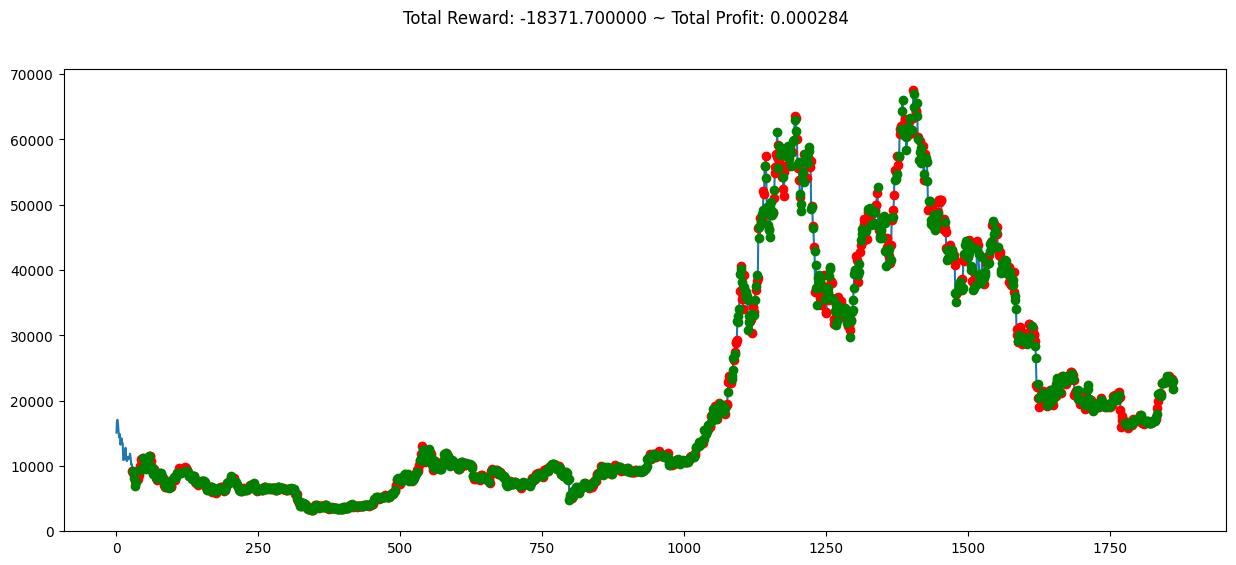

In [96]:
env = BitcoinEnv(df=df, window_size=28, frame_bound=(28, len(df)))
# Make this a vextorized env?

# This is a test run using random actions.
observation = env.reset()
while True:
    # Generate random actions
    action = env.action_space.sample()
    # Pass actions to environment
    observation, reward, done, info = env.step(action)
    if done: 
        print("info", info)
        break

plt.figure(figsize=(15, 6))
plt.cla()
env.render_all()

In [84]:
# Adjust all the models hyperparameters
model = RecurrentPPO('MlpLstmPolicy', # feed-forward neural network with multiple hidden layers
            env, # environment in which the agent interacts and learns
            verbose=1, # enables the training progress to be printed during the learning process
            gamma=0.95, # determines the importance of future rewards compared to immediate rewards
            n_steps=15, # steps to collect samples from the environment before performing an update
            ent_coef=0.01, # encourages exploration by adding entropy to the policy loss
            learning_rate=0.001, # controls the step size at which model's parameters are updated based on the gradient of the loss function
            clip_range=0.1, # limits the update to a certain range to prevent large policy updates
            batch_size=15)

model.learn(total_timesteps=1800)

#plt.figure(figsize=(15, 6))
#plt.cla()
#env.render_all()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------
| time/              |     |
|    fps             | 135 |
|    iterations      | 1   |
|    time_elapsed    | 0   |
|    total_timesteps | 15  |
----------------------------


d:\Python\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


------------------------------------------
| time/                   |              |
|    fps                  | 48           |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 30           |
| train/                  |              |
|    approx_kl            | 0.0022919497 |
|    clip_fraction        | 0.133        |
|    clip_range           | 0.1          |
|    entropy_loss         | -0.691       |
|    explained_variance   | -3.35        |
|    learning_rate        | 0.001        |
|    loss                 | -0.0398      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0217      |
|    value_loss           | 0.192        |
------------------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 52            |
|    iterations           | 3             |
|    time_elapsed         | 0             |
|    t